In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

2022-12-22 17:28:29.831437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('wgnd_noctry.csv',low_memory=False)

df = df[df.gender.isin(['M', 'F'])]

df['name'] = df['name'].apply(lambda x: str(x).lower())
df = df[[len(e)>1 for e in df.name]]
df = df.drop_duplicates()

names = df['name'].apply(lambda x: x.lower())
gender = df['gender']

df.head()

,name,gender
0,a hannan,M
1,a jay,M
2,a k i l,M
3,a lah,F
7,a rin,F


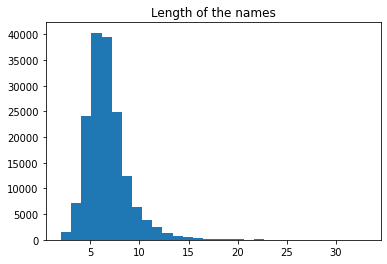

In [3]:
plt.hist([len(a) for a in names], bins=30)
plt.title('Length of the names')
plt.show()

In [4]:
print('Male : ' + str(sum(gender=='M')))
print('Female : ' + str(sum(gender=='F')))

Male : 67275
Female : 98809


In [5]:
vocab = set(' '.join([str(i) for i in names]))
vocab.add('END')
len_vocab = len(vocab)

In [6]:
char_index = dict((c, i) for i, c in enumerate(vocab))
print(char_index)

{'동': 0, '晧': 1, '옥': 2, '聖': 3, '盛': 4, '夏': 5, 'e': 6, '皓': 7, '彩': 8, '우': 9, '利': 10, '顯': 11, '후': 12, '慶': 13, '慧': 14, '오': 15, '鎭': 16, '桂': 17, '하': 18, '姢': 19, '龙': 20, '花': 21, 'END': 22, '家': 23, '霞': 24, '好': 25, 'd': 26, 'w': 27, 'h': 28, 'q': 29, '阳': 30, '자': 31, '琴': 32, '헌': 33, '朝': 34, '昊': 35, '치': 36, '志': 37, '이': 38, '珍': 39, '枝': 40, '구': 41, '보': 42, '廷': 43, '라': 44, '성': 45, '조': 46, '根': 47, '京': 48, '勳': 49, '允': 50, '훈': 51, '艳': 52, 'o': 53, '貞': 54, '胜': 55, '철': 56, '춘': 57, 'l': 58, '娟': 59, '梅': 60, '壽': 61, '荣': 62, 'a': 63, '宗': 64, '中': 65, '소': 66, '正': 67, '인': 68, '림': 69, '强': 70, '나': 71, '장': 72, 'c': 73, '연': 74, '原': 75, '明': 76, '람': 77, '애': 78, '景': 79, '子': 80, '병': 81, '地': 82, '芝': 83, '름': 84, '차': 85, '勛': 86, '道': 87, '열': 88, 'p': 89, '俊': 90, 'f': 91, '承': 92, '美': 93, '경': 94, '采': 95, '도': 96, 'x': 97, '震': 98, 'v': 99, '정': 100, 'y': 101, 'z': 102, '惠': 103, '凤': 104, '准': 105, '고': 106, '규': 107, '선': 108, '유': 109, '일': 11

In [7]:
maxlen = 20
labels = 2

X = []
y = []

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    tmp = np.zeros(len_vocab);
    tmp[i] = 1
    return list(tmp)

# Truncate names and create the matrix
def prepare_X(X):
    new_list = []
    trunc_train_name = [str(i)[0:maxlen] for i in X]
    for i in trunc_train_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index['END']))
        new_list.append(tmp)
    return new_list

X = prepare_X(names.values)

# Label Encoding of y
def prepare_y(y):
    new_list = []
    for i in y:
        if i == 'M':
            new_list.append([1,0])
        else:
            new_list.append([0,1])
    return new_list

y = prepare_y(gender)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:

model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), backward_layer=LSTM(128, return_sequences=True, go_backwards=True), input_shape=(maxlen,len_vocab)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax', activity_regularizer=l2(0.001)))

model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='max')

In [ ]:
epochs = 30
batch_size = 64
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test), callbacks=[callback, reduce_lr])